In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import sys
import math

In [2]:
# Some helper functions
def to_binary(n, z):
    l = []
    while n > 0:
       if n%2 == 0:
           l.append(0)
       else:
           l.append(1)
       n = n // 2
    while len(l) < z: 
        l.append(0)
    return l

to_index = lambda x: sum([2**i * j for i, j in enumerate(x)])

In [3]:
def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        

In [4]:
def generic_oracle(state, func, thresh, array, wires):
    #print(state)
    j = list(reversed(state))
   # print(f'Flipped:{j}',to_index(state),array[to_index(state)],func(state,array, thresh))
    if func(state, array, thresh) == True:
        #print(f'Flipped:{state}')
        qml.FlipSign(j, wires)

In [5]:
def generate_n_qubit_searcher(qubits, oracle, mapper, criterion, list_, thresh, iteration):
    wires = list(range(qubits))
    def circuit():
        equal_superposition(wires)
        qml.Snapshot("Uniform superposition |s>")
        for _ in range(iteration):
            for i in range(len(list_)):
                oracle(mapper(i), criterion, thresh, list_, wires)
            qml.Snapshot("State marked by Oracle")
            qml.templates.GroverOperator(wires)
        qml.Snapshot("Amplitude after diffusion")
        return qml.probs(wires=wires)
    return circuit

In [6]:
def less_than_builder(thresh, list_,iteration):
    #count qubits required
    qubit_count = math.ceil(math.log2(len(list_)))
    num_wires = qubit_count
    device = qml.device("default.qubit", wires=num_wires, shots=10)
    mapper = lambda x: to_binary(x, qubit_count)
    criterion = lambda x, list_, t: (t>list_[to_index(x)])
    circuit = generate_n_qubit_searcher(qubit_count, generic_oracle, mapper, criterion, list_, thresh,iteration)
    return qml.QNode(circuit, device)

In [7]:
def less_than_k(thresh, list_):
    if math.ceil(math.log2(len(list_))) != math.floor(math.log2(len(list_))):
        for i in range(len(list_), math.ceil(math.log2(len(list_)))):
            list_.append(sys.maxsize)
    circuit = less_than_builder(thresh, list_, iteration = 10*math.ceil(math.sqrt(len(list_))))
    qml.draw_mpl(circuit, style='sketch')()
    results = qml.snapshots(circuit)()
    execution_results = results['execution_results'][:len(list_)]
    print(results['State marked by Oracle'])
    print(execution_results)
    #plot_bar_graph(execution_results[:len(list_)], y_data=list_, x_label='Results', y_label='List').show()
    output = []
    for i in range(len(list_)):
        if np.float64(execution_results[i]) > np.float64(.10):
            output.append(list_[i])
    return output

[-0.18896249+0.j -0.18896249+0.j  0.42261539+0.j -0.18896249+0.j
 -0.18896249+0.j -0.18896249+0.j -0.18896249+0.j -0.18896249+0.j
 -0.18896249+0.j  0.42261539+0.j -0.18896249+0.j -0.18896249+0.j
  0.42261539+0.j -0.18896249+0.j -0.18896249+0.j -0.18896249+0.j]
[0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.2 0.1 0.  0. ]


[12, 3, 9]

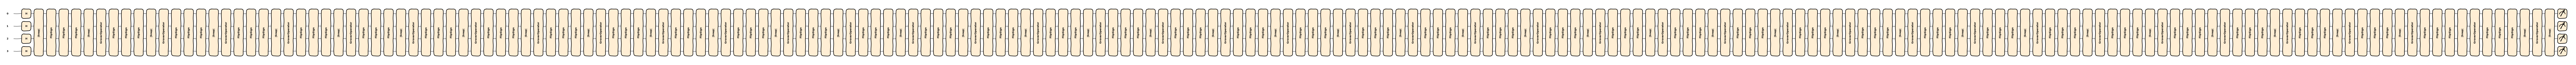

In [8]:
less_than_k (20,[89, 45, 12, 63, 27, 58, 91, 36, 74, 3, 67, 22, 9, 51, 82, 98])